# Assignment 2
### 14143630 Qinxuan Feng

# Introduction

In this assignment, I implement neural network algorithm to solve binary classification based on a simple practical dataset **Titanic**. Besides, another try is conducted on the dataset **Alzheimer**.

Single layer perceptron is a linear classifier and if the cases are not linearly separable the learning process will never reach a point where all the cases are classified properly. Multi-layer perceptron (MLP) can solve this problem.

A MLP has the same structure of a single layer perceptron with one or more hidden layers. The backpropagation algorithm consists of two phases: the forward phase where the activations are propagated from the input to the output layer, and the backward phase, where the error between the observed actual and the requested nominal value in the output layer is propagated backwards in order to modify the weights and bias values.

Multiple layers Neural Network will be made of :
1. An **Input Layer**, that pass the features to the NN
2. An arbitrary number of **Hidden Layers**, containing an arbitrary number of neurons for each layer, that receives the inputs and elaborate them. 
3. An **Output Layer**: these layers contains a number of neurons equal to the number of possible labels we want to have a prediction to; this is because the output of the NN is thus a vector whose dimension is the same as the cardinality of the set of labels, and its entries are the *probability* for each label for the element whose feateures we have passed to the NN. This means that we will use a sigmoid activator to the Output layer, so we squeeze each perceptron's output between 0 and 1. 

In this assignment, since it is a binary classification, so I just simply use a single-perceptron Output layer; If the output is smaller than 0.5, it belongs to one class, otherwise the other class.

For each layer, input a matrix made by columns of features that are labeled as $I=1,2$. Each of this features will have $n$ entries, so that each feature is a vector $\{x_I\}_i$. The layer will have $p$ perceptrons, labelled by $a=1,\ldots ,p$. Thus the output of the whole layer is a matrix ${O}^{(a)}_{(I)}$ given by
$${O}^{(a)}_{(I)} = \varphi\left( \mathbf{w}^{(a)}_{(I)} \cdot  \mathbf{x}^{(a)}_{(I)} + b^{(a)}_{(I)}   \right) ,$$

or, explicitly 
$${O}^{(a)}_{(I)} = \varphi ( {\large \Sigma}_{i=1}^{n} \left({w}^{(a)}_{(I)}\right)_i \left(  {x}^{(a)}_{(I)} \right)_i + \left( b^{(a)}_{(I)} \right)_i  )  .$$


# Dataset description

The dataset is coming from Kaggle **Titanic**.
It provides the information of the passengers and can be used to predict whether or not the person survived.

In [244]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(10)
%matplotlib inline
sns.set()

from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

data = pd.read_csv(r"E:\数据分析方法\titanic.csv",encoding='gbk')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Data preprocessing
This includes:

    transfer the categorical data to numerical data,like 0,1
    drop unescessary columns
    deal with the missing value
    identify the features and labels 

In [192]:
# define a dictionary to transform the 0,1 values in the labels to a String that defines the fate of the passenger
dict_live = { 
    0 : 'Perished',
    1 : 'Survived'
}

# define a dictionary to binarize the sex
dict_sex = {
    'male' : 0,
    'female' : 1
}

# apply the dictionary using a lambda function and the pandas .apply() module
data['Bsex'] = data['Sex'].apply(lambda x : dict_sex[x])


# Now the features are a 2 column matrix whose entries are the Class (1,2,3) and the Sex (0,1) of the passengers
features = data[['Pclass', 'Bsex']].to_numpy()
labels = data['Survived'].to_numpy()

## Train/Test split

split the set of features and labels into a training set and a test set.

In [193]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler 
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30)

print('Training records:',Y_train.size)
print('Test records:',Y_test.size)

# Feature scaling
scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test= scaler.transform(X_test)

Training records: 623
Test records: 268


# Neural network model

To implement the code as Class for Python, the goal is to have a class from which I can instantiate an object "Neural Network", and add to it as many hidden layers with as many neurons I want, with the desired activation functions and so on. 

Also the *Activation_function* class and the *layers* class are defined, so I may easily add more activation funtions or more different layers (such as Convolutional or Pooling layers for Convolutional Neural Networks).

In the **NN** class, it defines the following methods:
* **add**: it eats a tuple ( int(number_of_neurons), string(activation_function) ), i.e. the output of the NN.layer method. It is a void method. It updates the HiddenLayer string defined by the __init__ method. 
* **FeedForward**: it implements the Feed Forward layer by layer.
* **BackPropagation**: it implements the whole gradient descent mechanism; first, it computes the errors by implementing the backpropagation; then, it updates the NN parameters by gradient descent. 
* **Fit**: this method eats the training features and labels and fits the ANN by calling iteratively *FeedForward* and *BackPropagation* methods. This allow to easily modify (or generalize) either *FeedForward* or *BackPropagation* methods without altering the *Fit* method.
* **predict**: it eats the featurs and spits the label predictions. 
* **set_learning_rate**: by default the learning rate is initialized to be 1, but we can call this method to set it to a different value. 
* **get_loss, get_acc**: these methods' aim is to return the cost function and accuracy

In the **layers** class:
* **layer**: two inputs, the number of neurons and the activation function (as a string); it returns a tuple of the two. For adding multiple layers 

In the **Activation_functions** class: 
* **ReLU_act, sigmoid_act**, **softmax**: these are the activation functions. 

# NN class

In [217]:
'''
Neural Network Class
'''
class NN:
    
    '''
    Initialize the NN;
    HiddenLayer vector : will contain the Layers' info
    w, b, phi = (empty) arrays that will contain all the w, b and activation functions for all the Layers
    mu = cost function
    eta = a standard learning rate initialization. It can be modified by the 'set_learning_rate' method
    '''
    def __init__(self) :
        self.HiddenLayer = []
        self.w = []
        self.b = []
        self.phi = []
        self.mu = []
        self.J=[]
        self.eta = 1 #set up the proper Learning Rate!!
    
    '''
    add method: to add layers to the network
    '''
    def add(self, lay = (4, 'ReLU') ):
        self.HiddenLayer.append(lay)
    
    '''
    FeedForward method
    '''
    @staticmethod # can be called by class and instance
    def FeedForward(w, b, phi, x):
        return phi(np.dot(w, x) + b)
        
    '''
    BackPropagation algorithm implementing the Gradient Descent 
    '''
    def BackPropagation(self, x, z, Y, w, b, phi):
        self.delta = []#error array
        
        # Initialize ausiliar w and b that are used only inside the backpropagation algorithm once called        
        self.W = []
        self.B = []
        
        # Start computing the LAST error, the one for the OutPut Layer 
        self.delta.append(  (z[len(z)-1] - Y) *phi[len(z)-1](z[len(z)-1], der=True) )
 
        
        '''Backpropagate'''
        # Compute from next-to-last to first
        for i in range(0, len(z)-1):
            self.delta.append( np.dot( self.delta[i], w[len(z)- 1 - i] ) *phi[len(z)- 2 - i](z[len(z)- 2 - i], der=True) )
         
        # Now have the error array ordered from last to first; flip it to order it from first to last
        self.delta = np.flip(self.delta, 0)  
        
        # Now define the delta as the error divided by the number of training samples
        self.delta = self.delta/self.X.shape[0] 
        
        '''Gradient descent '''
        # Start from the first layer that is special, since it is connected to the Input Layer
        self.W.append( w[0] - self.eta * np.kron(self.delta[0], x).reshape( len(z[0]), x.shape[0] ) )
        self.B.append( b[0] - self.eta * self.delta[0] )
        
        # Now descend for all the other Hidden Layers + OutPut Layer
        for i in range(1, len(z)):
            self.W.append( w[i] - self.eta * np.kron(self.delta[i], z[i-1]).reshape(len(z[i]), len(z[i-1])) )
            self.B.append( b[i] - self.eta * self.delta[i] )
        
        # Return the descended parameters w, b
        return np.array(self.W), np.array(self.B)
    
    
    '''
    Fit method: it calls FeedForward and Backpropagation methods
    '''
    def Fit(self, X_train, Y_train,epochs):            
        print('Start fitting...')
        '''
        Input layer
        '''
        self.X = X_train
        self.Y = Y_train
        self.epochs=epochs
        '''
        Now initialize the Network by retrieving the Hidden Layers and concatenating them 
        '''
        print('Model recap: \n')
        print('You are fitting an NN model with the following amount of layers: ', len(self.HiddenLayer))
        
        for i in range(0, len(self.HiddenLayer)) :
            print('Layer ', i+1)
            print('Number of neurons: ', self.HiddenLayer[i][0])
            if i==0:
                self.w.append(2 * np.random.rand(self.HiddenLayer[i][0] , self.X.shape[1]) - 0.5)
                self.b.append(np.random.rand(self.HiddenLayer[i][0]))
                
                # Initialize the Activation function
                for act in Activation_function.list_act():
                    if self.HiddenLayer[i][1] == act :
                        self.phi.append(Activation_function.get_act(act))
                        print('\tActivation: ', act)

            else :      
                self.w.append(2*np.random.rand(self.HiddenLayer[i][0] , self.HiddenLayer[i-1][0] ) - 0.5)
                self.b.append(np.random.rand(self.HiddenLayer[i][0]))
                
                # Initialize the Activation function
                for act in Activation_function.list_act():
                    if self.HiddenLayer[i][1] == act :
                        self.phi.append(Activation_function.get_act(act))
                        print('\tActivation: ', act)
            
        '''
        Now start the Loop 
        '''  
        for k in range(self.epochs):
            for I in range(0, self.X.shape[0]): # loop over the training set
                '''
                Now start the feed forward
                '''  
                self.z = []
            
                self.z.append( self.FeedForward(self.w[0], self.b[0], self.phi[0], self.X[I]) ) # First layers
            
                for i in range(1, len(self.HiddenLayer)): #Looping over layers
                    self.z.append( self.FeedForward(self.w[i] , self.b[i], self.phi[i], self.z[i-1] ) )
        
            
                '''
                Here backpropagate
                '''      
                self.w, self.b  = self.BackPropagation(self.X[I], self.z, self.Y[I], self.w, self.b, self.phi)
            
                '''
                Compute cost function
                ''' 
                self.mu.append(
                    (1/2) * np.dot(self.z[len(self.z)-1] - self.Y[I], self.z[len(self.z)-1] - self.Y[I]) 
                )
            self.J.append(sum(self.mu)/len(self.mu))
            if k%10==0:
                print("Epochs: ",k)
                print("Loss:",self.J[k])
                print("Accuracy:",self.get_acc(self.X, self.Y))
        print('Fit done. \n')
        
    '''
    predict method
    '''
    def predict(self, X_test):
                
        self.pred = []
        self.XX = X_test
        
        for I in range(0, self.XX.shape[0]): # loop over the testing set
            
            '''
            Now start the feed forward
            '''  
            self.z = []
            
            self.z.append(self.FeedForward(self.w[0] , self.b[0], self.phi[0], self.XX[I])) #First layer
    
            for i in range(1, len(self.HiddenLayer)) : # loop over the layers
                self.z.append( self.FeedForward(self.w[i] , self.b[i], self.phi[i], self.z[i-1]))
       
            # Append the prediction;
            # Now need a binary classifier; apply an Heaviside Theta and set to 0.5 the threshold
            # if y < 0.5 the output is zero, otherwise is zero
            self.pred.append( np.heaviside( self.z[-1] - 0.5, 1)[0] )

        return np.array(self.pred)      
   
    '''
    A method to retrieve the accuracy for each training data to follow the learning of the NN
    '''
    def get_loss(self):
        return np.array(self.J)
    
    def get_acc(self,X_test,Y_test):
        pred=self.predict(X_test)
        return (np.sum(pred == Y_test) / Y_test.size)
    '''
    Method to set the learning rate
    '''
    def set_learning_rate(self, et=1):
        self.eta = et


# Layers class

In [218]:
'''
layers class
'''
class layers :
    '''
    Layer method: used to call standar layers to add. 
    '''        
    def layer(p=4, activation = 'ReLU'):
        return (p, activation)

# Activation_functions class

In [219]:
'''
Activation functions class
'''
class Activation_function(NN):
 
    def __init__(self) :
        super().__init__()
    

    '''
    Define the sigmoid activator
    '''
    def sigmoid_act(x, der=False):
        if (der==True) : #derivative of the sigmoid
            f = 1/(1+ np.exp(- x))*(1-1/(1+ np.exp(- x)))
        else : # sigmoid
            f = 1/(1+ np.exp(- x))
        return f

    '''
    Define the Rectifier Linear Unit (ReLU)
    '''
    def ReLU_act(x, der=False):
        if (der == True): # the derivative of the ReLU is the Heaviside Theta
            f = np.heaviside(x, 1)
        else :
            f = np.maximum(x, 0)
        return f
    def softmax_act(x,der=False):
        f = np.exp(x) / sum(np.exp(x))
        return f
    
    def list_act():
        return ['sigmoid', 'ReLU','softmax']
    
    def get_act(string = 'ReLU'):
        if string == 'ReLU':
            return Activation_function.ReLU_act
        elif string == 'sigmoid':
            return Activation_function.sigmoid_act
        elif string == 'softmax':
            return Activation_function.softmax_act
        else :
            return Activation_function.sigmoid_act

# Fitting the model

Now instantiate the model, a two-hidden layer with 8 and 4 neurons respectively and with ReLU activation plus an OutPut layer with a single neuron with sigmoid activation. 

set the learning rate and then fit the model;finally compute the predictions.

In [246]:
epochs=100
model = NN()

model.add(layers.layer(8, 'ReLU'))
model.add(layers.layer(4, 'ReLU'))
model.add(layers.layer(1, 'sigmoid'))

model.set_learning_rate(0.5)

model.Fit(X_train, Y_train,epochs)
loss_val = model.get_loss()


Start fitting...
Model recap: 

You are fitting an NN model with the following amount of layers:  3
Layer  1
Number of neurons:  8
	Activation:  ReLU
Layer  2
Number of neurons:  4
	Activation:  ReLU
Layer  3
Number of neurons:  1
	Activation:  sigmoid


E:\Anaconda 3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
E:\Anaconda 3\lib\site-packages\ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Epochs:  0
Loss: 0.30040206895665134
Accuracy: 0.39807383627608345
Epochs:  10
Loss: 0.17848492952707506
Accuracy: 0.6019261637239165
Epochs:  20
Loss: 0.15077262460785676
Accuracy: 0.6789727126805778
Epochs:  30
Loss: 0.13545793378751897
Accuracy: 0.7784911717495987
Epochs:  40
Loss: 0.12490442682901068
Accuracy: 0.7784911717495987
Epochs:  50
Loss: 0.11732387684676035
Accuracy: 0.7784911717495987
Epochs:  60
Loss: 0.1117774158683024
Accuracy: 0.7784911717495987
Epochs:  70
Loss: 0.10759538247621041
Accuracy: 0.7784911717495987
Epochs:  80
Loss: 0.10431631645083839
Accuracy: 0.7784911717495987
Epochs:  90
Loss: 0.10166554119529159
Accuracy: 0.7784911717495987
Fit done. 



# Evaluation

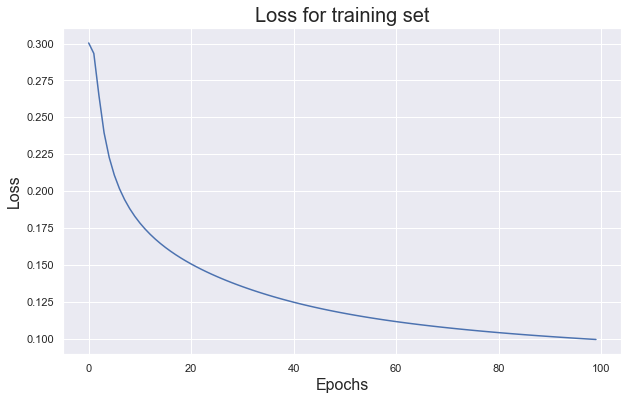

In [247]:
plt.figure(figsize=(10,6))
plt.plot(loss_val)
plt.title('Loss for training set', fontsize=20)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

In [248]:
model.get_acc(X_test,Y_test)

0.8059701492537313

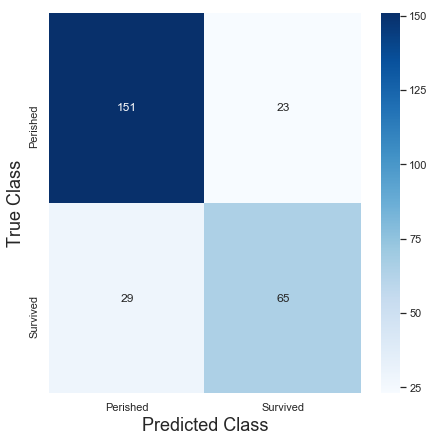

In [249]:
# Plot the confusion matrix
predictions=model.predict(X_test)
cm = confusion_matrix(Y_test, predictions)

df_cm = pd.DataFrame(cm, index = [dict_live[i] for i in range(0,2)], columns = [dict_live[i] for i in range(0,2)])
plt.figure(figsize = (7,7))
sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, fmt='g')
plt.xlabel("Predicted Class", fontsize=18)
plt.ylabel("True Class", fontsize=18)
plt.show()

# Another try 

This time I use the model to predict whether the person demented or not(on a Alzheimer dataset)

The dataset was generated by the Open Access Series of Imaging Studies (OASIS) project that is available both, on their website and kaggle that can be utilized for the purpose of training various machine learning models to identify patients with mild to moderate dementia.

In [250]:
df = pd.read_csv(r"E:\高级数据分析\ALZHEIMER\oasis_longitudinal.csv",encoding='gbk')
df.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [251]:
df['M/F'] = df['M/F'].replace(['F','M'], [0,1]) # M/F column
df['Group'] = df['Group'].replace(['Converted'], ['Demented']) # Target variable
df['Group'] = df['Group'].replace(['Demented', 'Nondemented'], [1,0]) # Target variable
df = df.drop(['MRI ID', 'Visit', 'Hand'], axis=1) # Drop unnecessary columns

In [252]:
df_dropna = df.dropna(axis=0, how='any')
pd.isnull(df_dropna).sum()

Subject ID    0
Group         0
MR Delay      0
M/F           0
Age           0
EDUC          0
SES           0
MMSE          0
CDR           0
eTIV          0
nWBV          0
ASF           0
dtype: int64

In [254]:
y = df_dropna['Group'].values # Target for the model
x = df_dropna[['M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']] # Features we use

# splitting into three sets
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3)

# Feature scaling
scaler = MinMaxScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test= scaler.transform(x_test)

In [266]:
epochs=500
model = NN()

model.add(layers.layer(8, 'ReLU'))
model.add(layers.layer(4, 'ReLU'))
model.add(layers.layer(1, 'sigmoid'))

model.set_learning_rate(0.5)

model.Fit(x_train, y_train,epochs)
loss_val = model.get_loss()

Start fitting...
Model recap: 

You are fitting an NN model with the following amount of layers:  3
Layer  1
Number of neurons:  8
	Activation:  ReLU
Layer  2
Number of neurons:  4
	Activation:  ReLU
Layer  3
Number of neurons:  1
	Activation:  sigmoid
Epochs:  0
Loss: 0.21252316030554097
Accuracy: 0.5910931174089069


E:\Anaconda 3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
E:\Anaconda 3\lib\site-packages\ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Epochs:  10
Loss: 0.12778791194501515
Accuracy: 0.6761133603238867
Epochs:  20
Loss: 0.11859382301951803
Accuracy: 0.6842105263157895
Epochs:  30
Loss: 0.11323995521625463
Accuracy: 0.6963562753036437
Epochs:  40
Loss: 0.10946785896632762
Accuracy: 0.7044534412955465
Epochs:  50
Loss: 0.10660144457424138
Accuracy: 0.7125506072874493
Epochs:  60
Loss: 0.10432374506857811
Accuracy: 0.7004048582995951
Epochs:  70
Loss: 0.10245576482255962
Accuracy: 0.708502024291498
Epochs:  80
Loss: 0.1008865208751265
Accuracy: 0.7044534412955465
Epochs:  90
Loss: 0.0995429922497305
Accuracy: 0.7165991902834008
Epochs:  100
Loss: 0.09837496210355327
Accuracy: 0.7246963562753036
Epochs:  110
Loss: 0.09734664153351363
Accuracy: 0.7206477732793523
Epochs:  120
Loss: 0.09643176328106895
Accuracy: 0.7327935222672065
Epochs:  130
Loss: 0.09561057224603767
Accuracy: 0.7327935222672065
Epochs:  140
Loss: 0.09486790265162146
Accuracy: 0.7327935222672065
Epochs:  150
Loss: 0.0941919040342473
Accuracy: 0.7287449392

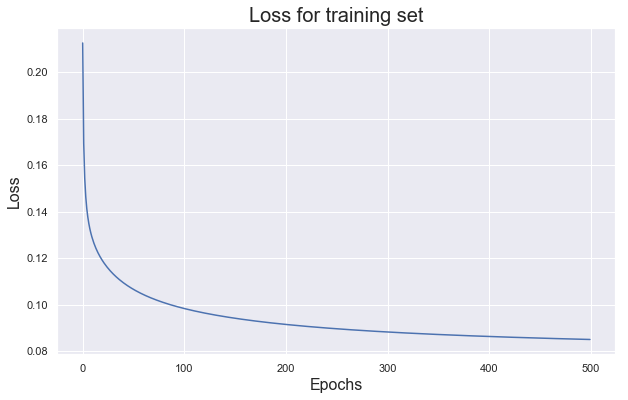

In [267]:
plt.figure(figsize=(10,6))
plt.plot(loss_val)
plt.title('Loss for training set', fontsize=20)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

In [268]:
model.get_acc(x_test,y_test)

0.7663551401869159

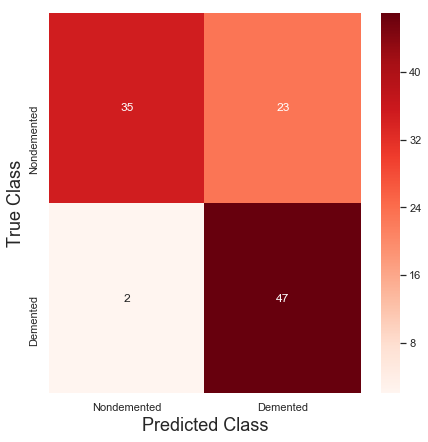

In [271]:
predictions=model.predict(x_test)
cm = confusion_matrix(y_test, predictions)

df_cm = pd.DataFrame(cm, index = ['Nondemented','Demented'], columns = ['Nondemented','Demented'])
plt.figure(figsize = (7,7))
sns.heatmap(df_cm, annot=True, cmap=plt.cm.Reds, fmt='g')
plt.xlabel("Predicted Class", fontsize=18)
plt.ylabel("True Class", fontsize=18)
plt.show()